In [2]:
# Install
# conda install -c conda-forge pystan
# pip install auto_ts
# conda install -c anaconda xlrd
# conda install -c plotly plotly

import numpy as np
import pandas as pd
import datetime
from auto_ts import auto_timeseries

In [3]:
# DATA
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv')
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [4]:
# Processing
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
# demand missing from 2017-08-10
df = df[df['timeStamp']<'2017-08-10']

# Resample
df = df.set_index('timeStamp')
df_daily = df[['demand', 'precip']].resample('D').sum()
temp = df.groupby(df.index.date)['temp'].agg(min_temp = 'min', max_temp = 'max', avg_temp = 'mean')
df_daily = df_daily.join(temp)
df_daily = df_daily.reset_index()

# Treat na
print('Initial na', df_daily.isna().sum().sum())
df_daily = df_daily.fillna(method='ffill')
print('Current na', df_daily.isna().sum().sum())
df_daily.head()

Initial na 3
Current na 0


,timeStamp,demand,precip,min_temp,max_temp,avg_temp
0,2012-01-01,118916.0,0.0597,38.78,50.77,46.510000
1,2012-01-02,127270.9,0.0000,33.57,49.78,40.496667
2,2012-01-03,146292.3,0.0000,16.47,33.14,26.672500
3,2012-01-04,152070.4,0.0000,13.40,31.83,20.585000
4,2012-01-05,147125.9,0.0000,27.31,39.16,33.577500


In [5]:
# Train/test split
train = df_daily[df_daily['timeStamp']<='2017-06-30']
test = df_daily[df_daily['timeStamp']>'2017-06-30']
print(train.shape)
print(test.shape)

(2008, 6)
(40, 6)


## Auto ts

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |      -4.248641100852327      |
|           p-value           |     0.000544525760730836     |
|          #Lags Used         |             28.0             |
| Number of Observations Used |            1979.0            |
|     Critical Value (1%)     |     -3.4336586419118653      |
|     Critical Value (5%)     |     -2.8630015713430743      |
|     Critical Value (10%)    |      -2.567548079537008      |
+-----------------------------+------------------------------+
 this series is stationary
    Target variable given as = demand
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_co

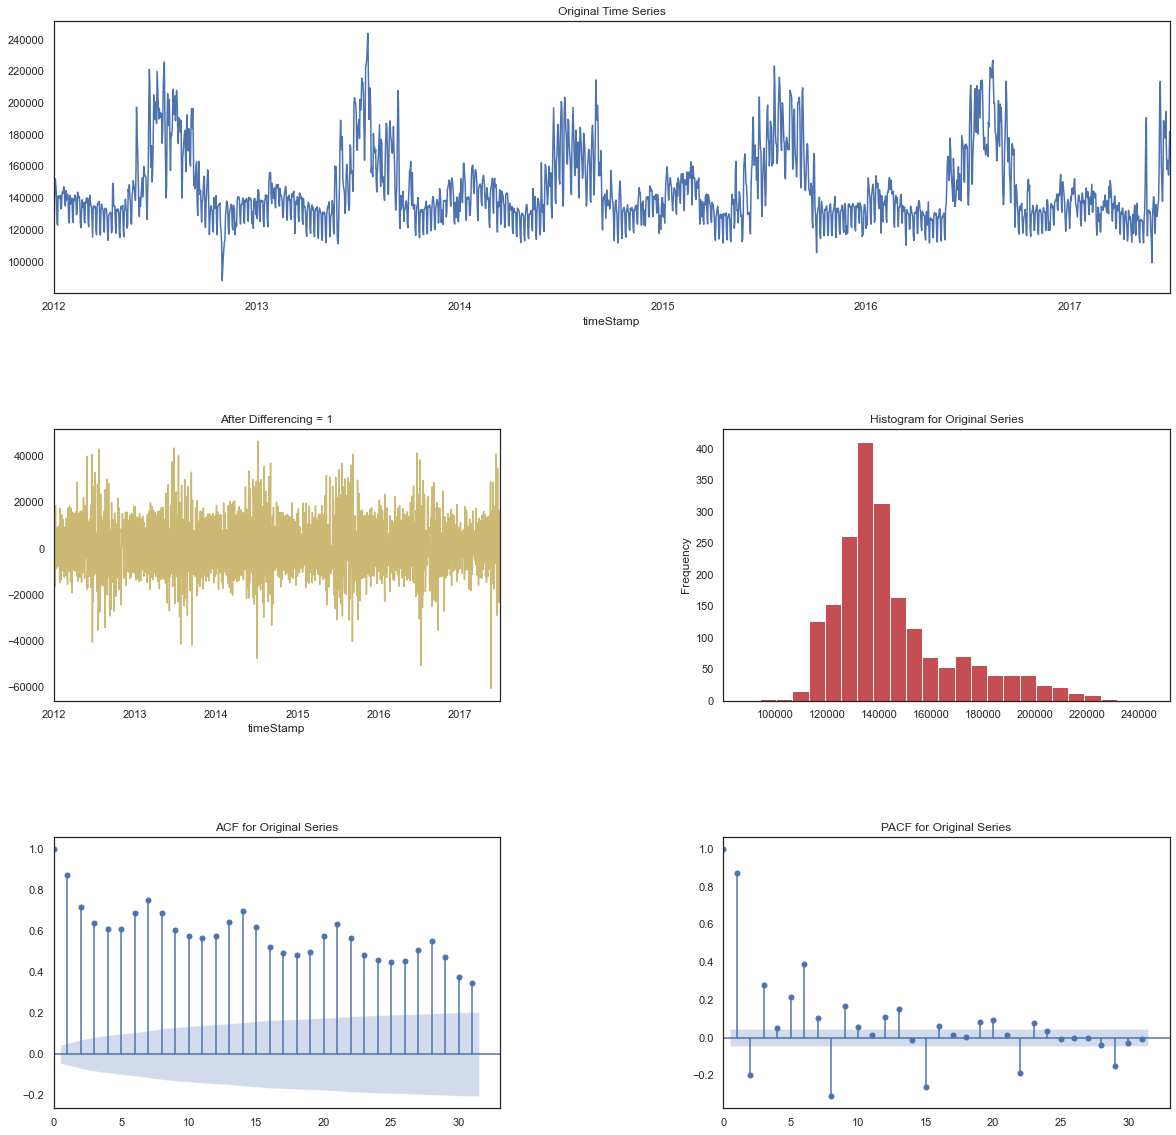

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(2008, 6)) with Confidence Interval = 0.95...
  Starting Prophet Fit
       Adding daily seasonality to Prophet with period=7, fourier_order=15 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 3

Fold Number: 1 --> Train Shape: 1888 Test Shape: 40
    Root Mean Squared Error predictions vs actuals = 5,825.35
    Std Deviation of actuals = 7,924.88
    Normalized RMSE = 74%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 1928 Test Shape: 40
    Root Mean Squared Error predictions vs actuals = 12,159.10
    Std Deviation of actuals = 15,378.18
    Normalized RMSE = 79%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 1968 Test Shape: 40
    Root Mean Squared Error predictions vs actuals = 20,


-------------------------------------------
Model Cross Validation Results:
-------------------------------------------
    MAE (as % Std Dev of Actuals) = 15.54%
    MAPE (Mean Absolute Percent Error) = 2%
    RMSE (Root Mean Squared Error) = 5294.2781
    Normalized RMSE (MinMax) = 5%
    Normalized RMSE (as Std Dev of Actuals)= 26%
Average CV RMSE of all predictions (micro) = 5294.27813

Fitting model on entire train set. Please be patient...
    Time taken to train model (in seconds) = 3

Best Model is: ML
    Best Model (Mean CV) Score: 4909.37


--------------------------------------------------
Total time taken: 496 seconds.
--------------------------------------------------


Leaderboard with best model on top of list:
            name          rmse
2            ML   4909.370485
0       Prophet  12963.840757
1  auto_SARIMAX  18855.280453


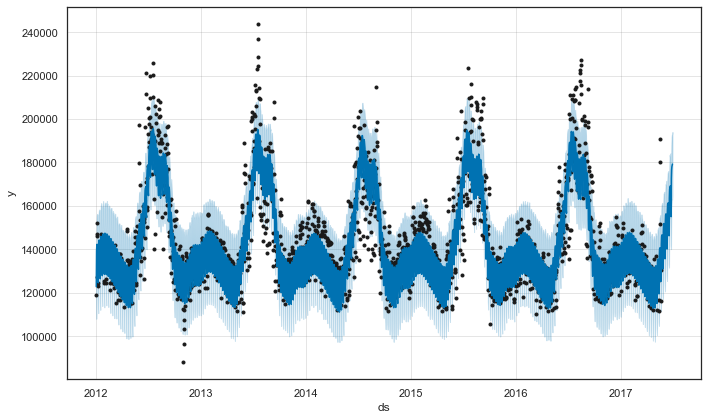

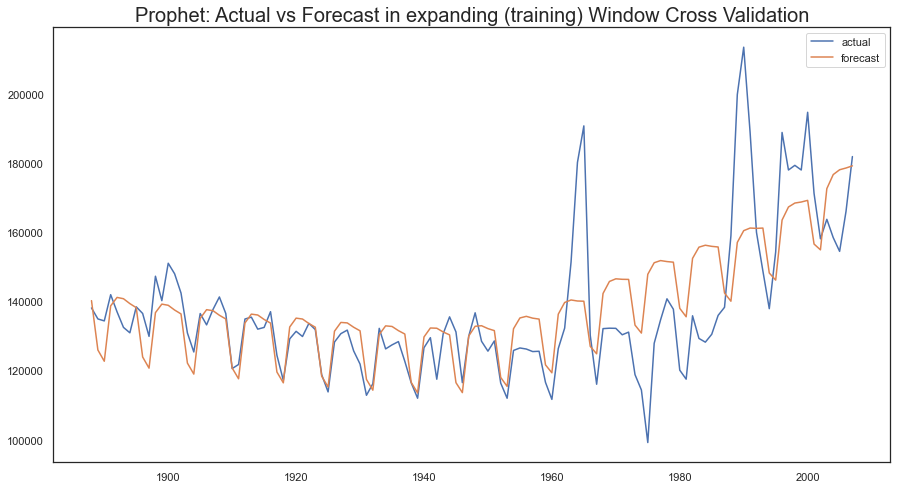

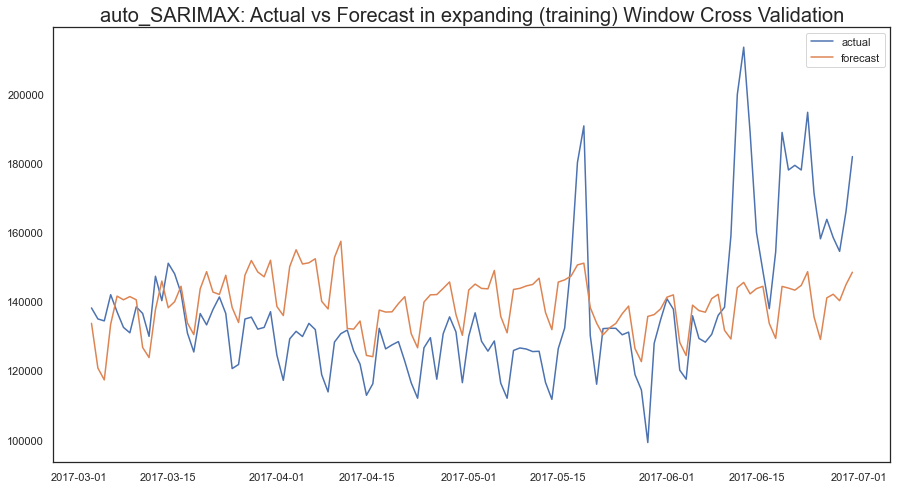

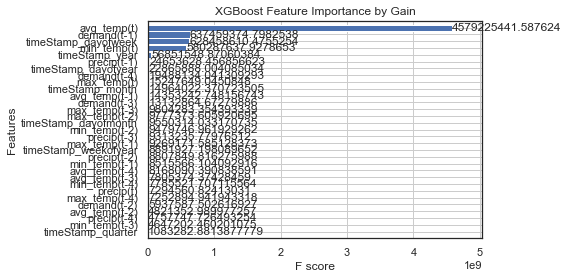

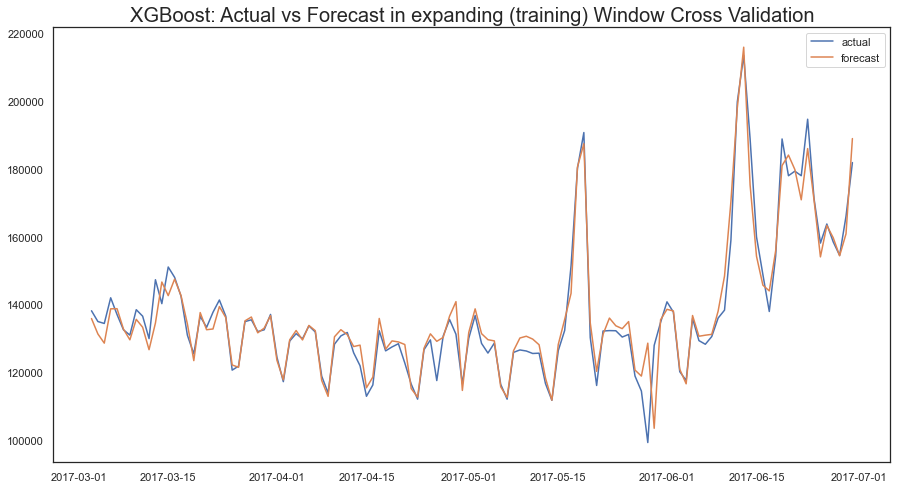

In [6]:
model = auto_timeseries(#train, 
#                           ts_column,
#                             target, sep,  
                            score_type='rmse', 
                            forecast_period=40,
                            time_interval='D',  
                            seasonality=True,
                            seasonal_period=7,
                            model_type=['best'],
                            verbose=2)


# CV is ts-based (rolling window), see the output
model.fit(traindata=train, ts_column='timeStamp', target='demand', cv=3, sep=",")

In [9]:
pred = model.predict(test, model='best')

For large datasets: ML predictions will take time since it has to predict each row and use that for future predictions...
    ML predictions completed


In [12]:
rmse_valid = np.sqrt(np.mean((pred['yhat'].values-test['demand'].values)**2))
mape_valid = np.mean(np.abs((pred['yhat'].values-test['demand'].values)/test['demand'].values))
print('Best auto_ts model validation results:')
print('RMSE_valid', rmse_valid)
print('mape_valid', mape_valid)

Best auto_ts model validation results:
RMSE_valid 9529.75265379919
mape_valid 0.042678760674061976
